In [2]:
# Common
import os
import keras
import numpy as np
from tqdm import tqdm
import cv2 as cv
from glob import glob
import tensorflow as tf

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras import Sequential
from keras.layers import Conv2D, Conv2DTranspose, InputLayer, Layer, Input, Dropout, MaxPool2D, concatenate
from keras.optimizers import Adam
import cv2
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
images,masks=[],[]

for i in range(300):
    image_path=os.path.join('D:\Projects\Trinetra Datasets\Dataset\Images',os.listdir('D:\Projects\Trinetra Datasets\Dataset\Images')[i])
    masks_path=os.path.join('D:\Projects\Trinetra Datasets\Dataset\Masks',os.listdir('D:\Projects\Trinetra Datasets\Dataset\Masks')[i])
    
    img=cv2.imread(image_path)
    mask=cv2.imread(masks_path)

    img=img/255
    mask=mask/255

    img = cv2.GaussianBlur(img, (1, 1), 0)
    mask = cv2.GaussianBlur(mask, (1, 1), 0)

    images.append(img)
    masks.append(mask)

images=np.array(images)
masks=np.array(masks)

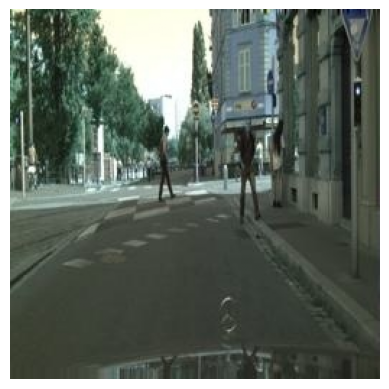

In [4]:
plt.imshow(images[45])
plt.axis('off')
plt.show()

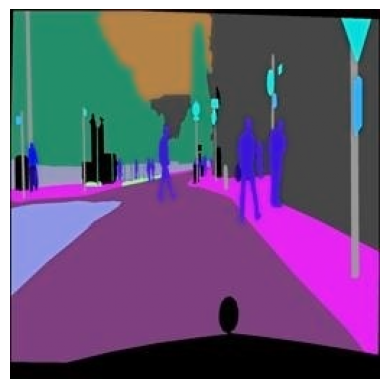

In [5]:
plt.imshow(masks[45])
plt.axis('off')
plt.show()

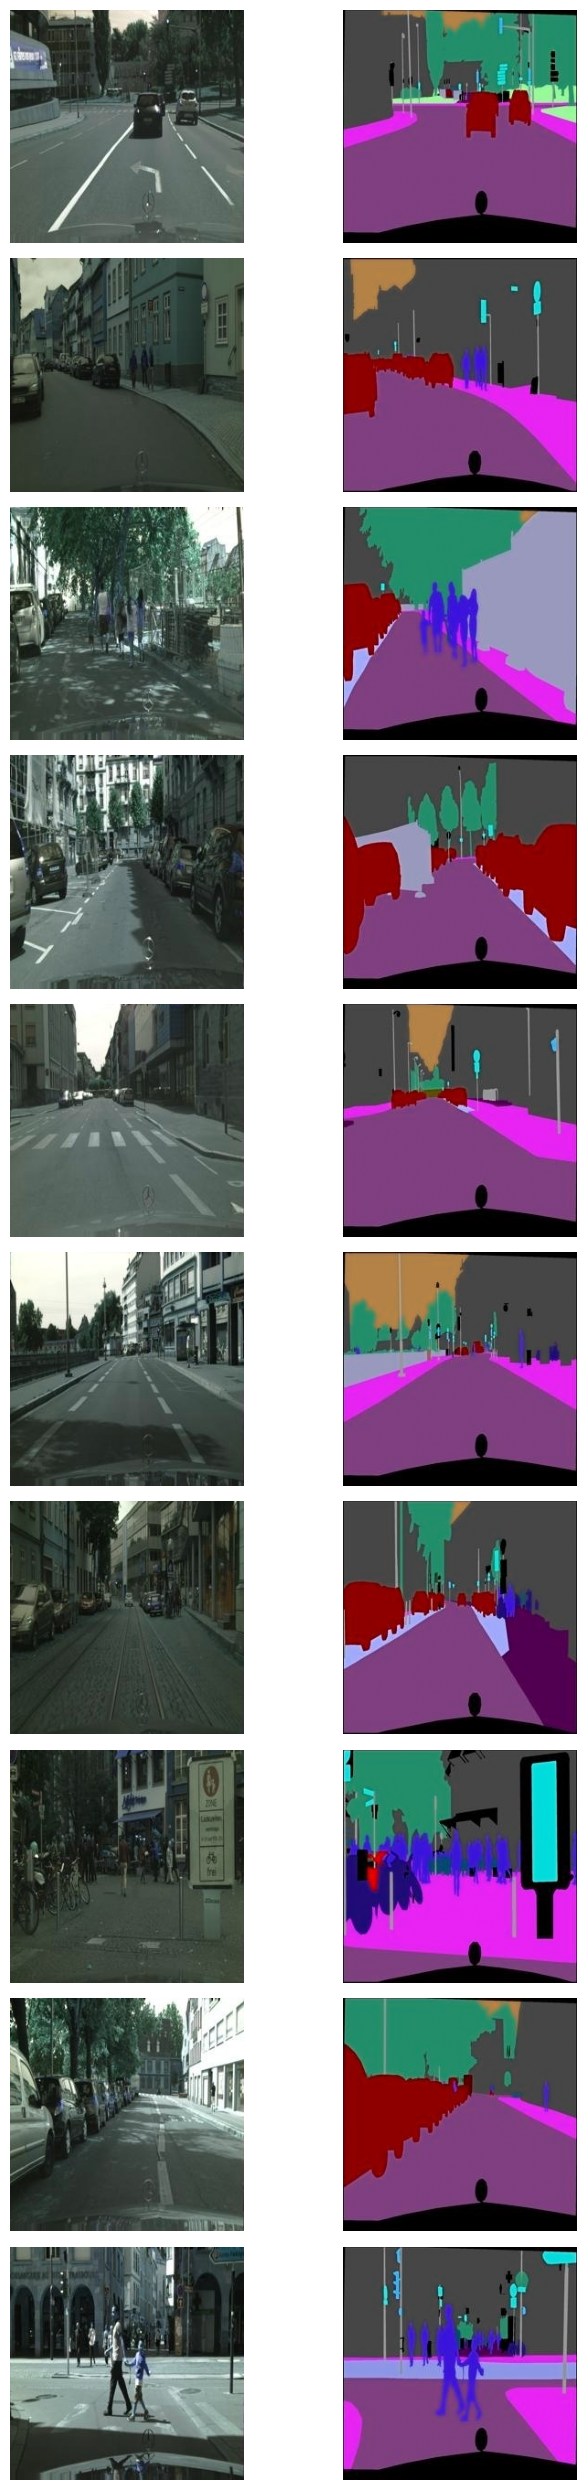

In [6]:
plt.figure(figsize=(8,25))
for i in range(1,21):
    plt.subplot(10,2,i)
    if i%2!=0:
        id = np.random.randint(len(images))
        image = images[id]
        plt.imshow(image)
        plt.axis('off')
    elif i%2==0:
        mask = masks[id]
        plt.imshow(mask)
        plt.axis('off')  
plt.tight_layout()
plt.show()

In [7]:
X_train, y_train = images[:200], masks[:200]
X_valid, y_valid = images[100:], masks[100:]

In [8]:
class EncoderLayerBlock(Layer):
    def __init__(self, filters, rate, pooling=True):
        super(EncoderLayerBlock, self).__init__()
        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(self.rate)
        self.c2 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D(pool_size=(2,2))

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else: 
            return x

    def get_config(self):
        base_estimator = super().get_config()
        return {
            **base_estimator,
            "filters":self.filters,
            "rate":self.rate,
            "pooling":self.pooling
        }

#  Decoder Layer
class DecoderLayerBlock(Layer):
    def __init__(self, filters, rate, padding='same'):
            super(DecoderLayerBlock, self).__init__()
            self.filters = filters
            self.rate = rate
            self.cT = Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding=padding)
            self.next = EncoderLayerBlock(self.filters, self.rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.cT(X)
        c1 = concatenate([x, skip_X])
        y = self.next(c1)
        return y 

    def get_config(self):
        base_estimator = super().get_config()
        return {
            **base_estimator,
            "filters":self.filters,
            "rate":self.rate,
        }

#  Callback 
class ShowProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        id = np.random.randint(len(X_valid))
        rand_img = X_valid[id][np.newaxis,...]
        pred_mask = self.model.predict(rand_img)[0]
        true_mask = y_valid[id]


        plt.subplot(1,3,1)
        plt.imshow(rand_img[0])
        plt.title("Original Image")
        plt.axis('off')


        plt.subplot(1,3,2)
        plt.imshow(pred_mask)
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(true_mask)
        plt.title("True Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

Epoch 1/50
1/1 [==============================] - 1s 833ms/steps: 0.7040 - accuracy: 0.3917 - mean_io_u: 0.499


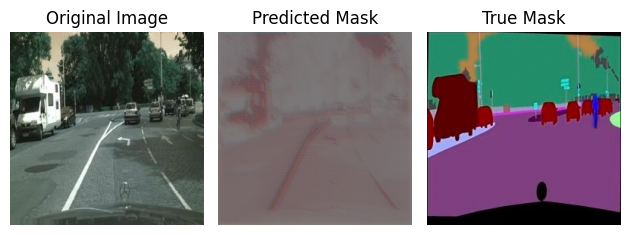

7/7 [==============================] - 175s 25s/step - loss: 0.7040 - accuracy: 0.3917 - mean_io_u: 0.4999 - val_loss: 0.6642 - val_accuracy: 0.4365 - val_mean_io_u: 0.4999
Epoch 2/50
1/1 [==============================] - 0s 178ms/steps: 0.6630 - accuracy: 0.3799 - mean_io_u: 0.499


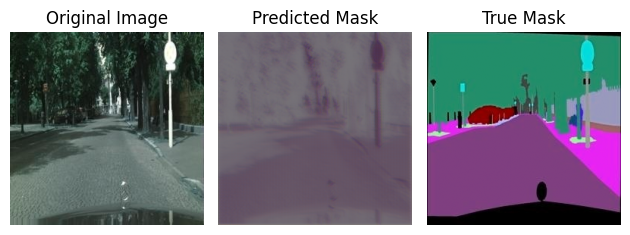

7/7 [==============================] - 186s 27s/step - loss: 0.6630 - accuracy: 0.3799 - mean_io_u: 0.4999 - val_loss: 0.6507 - val_accuracy: 0.4082 - val_mean_io_u: 0.4999
Epoch 3/50
1/1 [==============================] - 0s 233ms/steps: 0.6540 - accuracy: 0.4097 - mean_io_u: 0.499


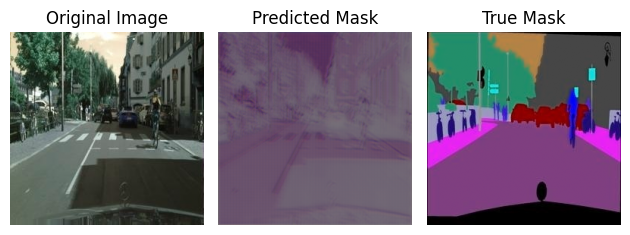

7/7 [==============================] - 158s 23s/step - loss: 0.6540 - accuracy: 0.4097 - mean_io_u: 0.4999 - val_loss: 0.6460 - val_accuracy: 0.4037 - val_mean_io_u: 0.4999
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.6487 - accuracy: 0.4157 - mean_io_u: 0.4999 

In [9]:
with tf.device('/GPU:1'):
    # Input Layer 
    input_layer = Input(shape=X_train.shape[-3:])

    # Encoder
    p1, c1 = EncoderLayerBlock(16,0.1)(input_layer)
    p2, c2 = EncoderLayerBlock(32,0.1)(p1)
    p3, c3 = EncoderLayerBlock(64,0.2)(p2)
    p4, c4 = EncoderLayerBlock(128,0.2)(p3)

    # Encoding Layer
    c5 = EncoderLayerBlock(256,0.3,pooling=False)(p4)

    # Decoder
    d1 = DecoderLayerBlock(128,0.2)([c5, c4])
    d2 = DecoderLayerBlock(64,0.2)([d1, c3])
    d3 = DecoderLayerBlock(32,0.2)([d2, c2])
    d4 = DecoderLayerBlock(16,0.2)([d3, c1])

    # Output layer
    output = Conv2D(3,kernel_size=1,strides=1,padding='same',activation='sigmoid')(d4)

    # U-Net Model
    model = keras.models.Model(
        inputs=[input_layer],
        outputs=[output],
    )

    # Compiling
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2)]
    )

    # Callbacks 
    callbacks =[
        ModelCheckpoint("UNet-Colorizer.h5", save_best_only=True),
        ShowProgress()
    ]

    # Train The Model
    model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=2000,
        callbacks=callbacks
    )

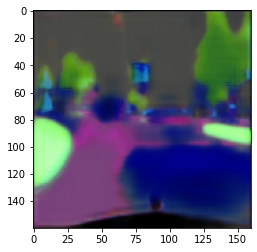

In [18]:
img='../input/cityscapes-image-pairs/cityscapes_data/train/1.jpg'
import cv2
im=cv2.imread(img)
im=im[:,256:,:]
im=cv2.resize(im,(160,160))
im=np.array(im)
im=im/255
im=np.expand_dims(im,axis=0)
pred=model.predict(im)
plt.imshow(pred[0])
plt.show()

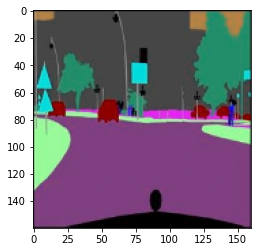

In [19]:
img='../input/cityscapes-image-pairs/cityscapes_data/train/1.jpg'
import cv2
im=cv2.imread(img)
im=im[:,256:,:]
im=cv2.resize(im,(160,160))
im=np.array(im)
im=im/255
plt.imshow(im)
plt.show()